## Overview:  
This capstone project is your opportunity to demonstrate the knowledge and abilities you have acquired throughout the course.
This Capstone Project requires learners to work with the following technologies to manage an ETL process for a Loan Application dataset and a Credit Card dataset: Python (Pandas, advanced modules e.g., Matplotlib), MariaDB, Apache Spark (Spark Core, Spark SQL), and Python Visualization and Analytics libraries. Learners are expected to set up their environments and perform installations on their local machines. 


![My Image](workflow.jpg)

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType,TimestampType,StructField,StructType
from datetime import datetime
import pyspark.sql.functions as F
from pyspark.sql.functions import  concat_ws, regexp_replace, concat,lit,col,udf, lpad,when, length,expr,substring
import re
import requests
import json
from pyspark import SparkContext, SparkConf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import configparser
import pyinputplus as pyip



In [37]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['DATABASE']['host']
user = config['DATABASE']['user']
password = config['DATABASE']['password']
database = config['DATABASE']['database']

In [6]:
spark = SparkSession.builder.appName("CreditCardSystem").getOrCreate()


In [38]:
branch_df=spark.read.json("cdw_sapp_branch.json")
creditcard_df=spark.read.json("cdw_sapp_credit.json")
customer_df=spark.read.json("cdw_sapp_custmer.json")


In [19]:
spark.stop()

### Transform Customer Data frame

In [6]:
# add area code 555 as the first 3 characters for customer phone number, so we can  convert cust_phone column into this format (XXX)XXX-XXXX later
customer_df = customer_df.withColumn("CUST_PHONE", concat(lit("555"), customer_df["CUST_PHONE"]))

In [7]:
customer_df = customer_df.withColumn("cust_phone", 
                   expr("concat('(', substring(cust_phone, 1, 3), ')',  " 
                        "substring(cust_phone, 4, 3), '-', "
                        "substring(cust_phone, 7, 4))").cast("string"))
 
customer_df = customer_df.withColumn("FIRST_NAME", F.initcap("FIRST_NAME").cast("string"))
customer_df = customer_df.withColumn("SSN", customer_df["SSN"].cast("int"))
customer_df = customer_df.withColumn("MIDDLE_NAME", F.lower(customer_df["MIDDLE_NAME"]).cast("string"))
customer_df = customer_df.withColumn("LAST_NAME", F.initcap(customer_df["LAST_NAME"]).cast("string"))
customer_df = customer_df.withColumn("FULL_STREET_ADDRESS", F.concat_ws(", ", customer_df["APT_NO"],customer_df["STREET_NAME"]).cast("string"))
customer_df = customer_df.withColumn("CREDIT_CARD_NO", customer_df["CREDIT_CARD_NO"].cast("string"))
customer_df = customer_df.withColumn("CUST_CITY", customer_df["CUST_CITY"].cast("string"))
customer_df = customer_df.withColumn("CUST_STATE", customer_df["CUST_STATE"].cast("string"))
customer_df = customer_df.withColumn("CUST_COUNTRY", customer_df["CUST_COUNTRY"].cast("string"))
customer_df = customer_df.withColumn("CUST_ZIP", customer_df["CUST_ZIP"].cast("int"))

 
#customer_df = customer_df.withColumn("CUST_PHONE", F.regexp_replace(customer_df["CUST_PHONE"], r'^(\d{3})(\d{3})(\d{4})$', r'(\1)\2-\3').cast("string"))
customer_df = customer_df.withColumn("CUST_EMAIL", customer_df["CUST_EMAIL"].cast("string"))
customer_df = customer_df.withColumn("LAST_UPDATED", customer_df["LAST_UPDATED"].cast("timestamp"))

customer_df=customer_df.select("SSN", "FIRST_NAME","MIDDLE_NAME","LAST_NAME","CREDIT_CARD_NO","FULL_STREET_ADDRESS","CUST_CITY", "CUST_STATE","CUST_COUNTRY","CUST_ZIP","CUST_PHONE","CUST_EMAIL","LAST_UPDATED")

In [7]:
customer_df.printSchema()

root
 |-- SSN: integer (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = false)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_ZIP: integer (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



In [8]:
customer_df.describe().show()

+-------+--------------------+----------+-----------+---------+--------------------+-------------------+---------+----------+-------------+------------------+-------------+--------------------+
|summary|                 SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|      CREDIT_CARD_NO|FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|          CUST_ZIP|   CUST_PHONE|          CUST_EMAIL|
+-------+--------------------+----------+-----------+---------+--------------------+-------------------+---------+----------+-------------+------------------+-------------+--------------------+
|  count|                 952|       952|        952|      952|                 952|                952|      952|       952|          952|               952|          952|                 952|
|   mean|1.2345552588130252E8|      null|       null|     null|4.210653353718597...|               null|     null|      null|         null|36312.616596638654|         null|                null|
| stddev|  2561.1858044909427|

In [8]:
customer_df.show(5)


+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|656, Main Street ...|     Natchez|        MS|United States|   39120|(555)123-7818|AHooper@example.com|2018-04-21 12:49:02|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  829, Redwood Drive|Wethersfield|        CT|United States|    6109|(555)123-8933|EHolman@example.com|2018-04-21 12:49:02|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|683, 12th Street ..

### transform branch data frame

In [9]:
# Convert column data types


branch_df = branch_df.withColumn("BRANCH_PHONE", 
                   expr("concat('(', substring(BRANCH_PHONE, 1, 3), ')',  " 
                        "substring(BRANCH_PHONE, 4, 3), '-', "
                        "substring(BRANCH_PHONE, 7, 4))").cast("string"))

branch_df = branch_df.withColumn("BRANCH_CODE", branch_df["BRANCH_CODE"].cast("int"))
branch_df = branch_df.withColumn("BRANCH_NAME", branch_df["BRANCH_NAME"].cast("string"))
branch_df = branch_df.withColumn("BRANCH_STREET", branch_df["BRANCH_STREET"].cast("string"))
branch_df = branch_df.withColumn("BRANCH_CITY", branch_df["BRANCH_CITY"].cast("string"))
branch_df = branch_df.withColumn("BRANCH_STATE", branch_df["BRANCH_STATE"].cast("string"))
branch_df = branch_df.withColumn("BRANCH_ZIP", F.when(branch_df["BRANCH_ZIP"].isNull(), 99999).otherwise(branch_df["BRANCH_ZIP"].cast("int")))
#branch_df = branch_df.withColumn("BRANCH_PHONE", F.regexp_replace(branch_df["BRANCH_PHONE"], r"^(\d{3})(\d{3})(\d{4})$", r"(\1)\2-\3"))
branch_df = branch_df.withColumn("LAST_UPDATED", branch_df["LAST_UPDATED"].cast("timestamp"))

# Select columns 
branch_df = branch_df.select("BRANCH_CODE", "BRANCH_NAME", "BRANCH_STREET", "BRANCH_CITY", "BRANCH_STATE", "BRANCH_ZIP", "BRANCH_PHONE", "LAST_UPDATED")

In [11]:
branch_df.printSchema()

root
 |-- BRANCH_CODE: integer (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_ZIP: integer (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



In [12]:
branch_df.describe().show()

+-------+-----------------+------------+-------------+-----------+------------+------------------+-------------+
|summary|      BRANCH_CODE| BRANCH_NAME|BRANCH_STREET|BRANCH_CITY|BRANCH_STATE|        BRANCH_ZIP| BRANCH_PHONE|
+-------+-----------------+------------+-------------+-----------+------------+------------------+-------------+
|  count|              115|         115|          115|        115|         115|               115|          115|
|   mean|76.67826086956522|        null|         null|       null|        null|  38975.2347826087|         null|
| stddev|52.94113709535237|        null|         null|       null|        null|23938.156819564818|         null|
|    min|                1|Example Bank|  11th Street|    Acworth|          AL|              2155|(123)410-5725|
|    max|              197|Example Bank|  York Street|   YubaCity|          WI|             98908|(123)498-5926|
+-------+-----------------+------------+-------------+-----------+------------+-----------------

In [13]:
branch_df.show(5)

+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|BRANCH_CODE| BRANCH_NAME|    BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP| BRANCH_PHONE|       LAST_UPDATED|
+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|          1|Example Bank|     Bridle Court|        Lakeville|          MN|     55044|(123)456-5276|2018-04-18 16:51:47|
|          2|Example Bank|Washington Street|          Huntley|          IL|     60142|(123)461-8993|2018-04-18 16:51:47|
|          3|Example Bank|    Warren Street|SouthRichmondHill|          NY|     11419|(123)498-5926|2018-04-18 16:51:47|
|          4|Example Bank| Cleveland Street|       Middleburg|          FL|     32068|(123)466-3064|2018-04-18 16:51:47|
|          5|Example Bank|      14th Street|    KingOfPrussia|          PA|     19406|(123)484-9701|2018-04-18 16:51:47|
+-----------+------------+------

### TRANSFORM CREDIT CARD DATA 

In [10]:
# Convert DAY, MONTH and YEAR into date format and create new column TIMEID with YYYYMMDD format
creditcard_df = creditcard_df.withColumn('TIMEID', concat(creditcard_df.YEAR, lpad(creditcard_df.MONTH, 2, '0'), lpad(creditcard_df.DAY, 2, '0')).cast('int'))


In [11]:
 


# Rename CREDIT_CARD_NO column as per the mapping document
creditcard_df = creditcard_df.withColumnRenamed('CREDIT_CARD_NO', 'CUST_CC_NO') 

# Convert datatype of columns as per the mapping document
creditcard_df = creditcard_df.withColumn('CUST_CC_NO', creditcard_df['CUST_CC_NO'].cast('string')) 
creditcard_df = creditcard_df.withColumn('CUST_SSN', creditcard_df['CUST_SSN'].cast('int')) 
creditcard_df = creditcard_df.withColumn('BRANCH_CODE', creditcard_df['BRANCH_CODE'].cast('int')) 
creditcard_df = creditcard_df.withColumn('TRANSACTION_TYPE', creditcard_df['TRANSACTION_TYPE'].cast('string')) 
creditcard_df = creditcard_df.withColumn('TRANSACTION_VALUE', creditcard_df['TRANSACTION_VALUE'].cast('double')) 
creditcard_df = creditcard_df.withColumn('TRANSACTION_ID', creditcard_df['TRANSACTION_ID'].cast('int')) 
creditcard_df = creditcard_df.withColumn('TIMEID', creditcard_df['TIMEID'].cast('string'))
creditcard_df=creditcard_df.select("CUST_CC_NO","TIMEID","CUST_SSN","BRANCH_CODE","TRANSACTION_TYPE","TRANSACTION_VALUE","TRANSACTION_ID")
 


In [16]:
creditcard_df.printSchema()

root
 |-- CUST_CC_NO: string (nullable = true)
 |-- TIMEID: string (nullable = true)
 |-- CUST_SSN: integer (nullable = true)
 |-- BRANCH_CODE: integer (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)



In [12]:
creditcard_df.show(10)

+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|      CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|
|4210653349028689|20180320|123459988|         35|   Entertainment|            14.24|             2|
|4210653349028689|20180708|123459988|        160|         Grocery|             56.7|             3|
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|
|4210653349028689|20180528|123459988|        164|       Education|             6.89|             6|
|4210653349028689|20180519|123459988|        119|   Entertainment|            43.39|             7|


In [18]:
creditcard_df.describe().show()

+-------+--------------------+------------------+-------------------+------------------+----------------+------------------+------------------+
|summary|          CUST_CC_NO|            TIMEID|           CUST_SSN|       BRANCH_CODE|TRANSACTION_TYPE| TRANSACTION_VALUE|    TRANSACTION_ID|
+-------+--------------------+------------------+-------------------+------------------+----------------+------------------+------------------+
|  count|               46694|             46694|              46694|             46694|           46694|             46694|             46694|
|   mean|4.210653353368964E15|2.01806661949501E7|1.234555184812824E8| 75.00057823274939|            null| 51.03938214759932|           23347.5|
| stddev|2.5604641248039957E7|345.41894155270205| 2561.2609103365367|51.389074910957895|            null|28.783264046884938|13479.541071564714|
|    min|    4210653310061055|          20180101|          123451007|                 1|           Bills|              1.01|            

### Load data into Database

In [19]:
# Connect to MariaDB server
try:
    cnx = mysql.connector.connect(user=user, password=password,
                              host=host)

    # Create database
    cursor = cnx.cursor()
    DB_NAME = 'creditcard_capstone'
    cursor.execute("CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(DB_NAME))
    
except mysql.connector.Error as err:
    print("Error connecting to MariaDB: {}".format(err))
    exit()

Error connecting to MariaDB: 1007 (HY000): Can't create database 'creditcard_capstone'; database exists


In [20]:
# Connect to mariadb

try:
    cnx = mysql.connector.connect(user=user, password=password,
                              host=host,
                              database=database)
    cursor = cnx.cursor()

except mysql.connector.Error as err:
    print("Error connecting to MariaDB: {}".format(err))
    exit()

In [21]:
try:
    cursor.execute("""CREATE TABLE IF NOT EXISTS CDW_SAPP_BRANCH (
        BRANCH_CODE INT PRIMARY KEY, 
        BRANCH_NAME VARCHAR(50) NOT NULL, 
        BRANCH_STREET VARCHAR(100) NOT NULL, 
        BRANCH_CITY VARCHAR(50) NOT NULL, 
        BRANCH_STATE VARCHAR(50) NOT NULL, 
        BRANCH_ZIP INT NOT NULL, 
        BRANCH_PHONE VARCHAR(20) NOT NULL, 
        LAST_UPDATED TIMESTAMP NOT NULL)""")
    
    cursor.execute("""CREATE TABLE IF NOT EXISTS CDW_SAPP_CREDIT_CARD (
        CUST_CC_NO VARCHAR(50) PRIMARY KEY, 
        TIMEID VARCHAR(8)NOT NULL, 
        CUST_SSN INT NOT NULL, 
        BRANCH_CODE INT NOT NULL, 
        TRANSACTION_TYPE VARCHAR(20) NOT NULL, 
        TRANSACTION_VALUE DOUBLE NOT NULL, 
        TRANSACTION_ID INT NOT NULL)""")
    
    cursor.execute("""CREATE TABLE IF NOT EXISTS CDW_SAPP_CUSTOMER (
        SSN INT PRIMARY KEY, 
        CREDIT_CARD_NO VARCHAR(50) NOT NULL, 
        CUST_FIRST_NAME VARCHAR(50) NOT NULL, 
        CUST_MIDDLE_NAME VARCHAR(50) NOT NULL, 
        CUST_LAST_NAME VARCHAR(50) NOT NULL, 
        CUST_STREET_ADDRESS VARCHAR(100) NOT NULL, 
        CUST_APT_NO VARCHAR(10) NOT NULL, 
        CUST_CITY VARCHAR(50) NOT NULL, 
        CUST_STATE VARCHAR(50) NOT NULL, 
        CUST_COUNTRY VARCHAR(50) NOT NULL, 
        CUST_ZIP INT NOT NULL, 
        CUST_PHONE VARCHAR(10) NOT NULL, 
        CUST_EMAIL VARCHAR(50) NOT NULL, 
        LAST_UPDATED TIMESTAMP NOT NULL)""")
    
except mysql.connector.Error as err:
    print("Error creating tables: {}".format(err))
    exit()


In [ ]:
# Load the data into the database tables
try:
    branch_df.write.jdbc(url='jdbc:mysql://localhost:3306/creditcard_capstone', table='CDW_SAPP_BRANCH', mode='overwrite', properties={'user': user, 'password': password})
    creditcard_df.write.jdbc(url='jdbc:mysql://localhost:3306/creditcard_capstone', table='CDW_SAPP_CREDIT_CARD', mode='overwrite', properties={'user': user, 'password': password})
    customer_df.write.jdbc(url='jdbc:mysql://localhost:3306/creditcard_capstone', table='CDW_SAPP_CUSTOMER', mode='overwrite', properties={'user': user, 'password': password})
    cnx.commit() # commit the changes
    
    # Close the database and cursor connection
    cursor.close()
    cnx.close()
except mysql.connector.Error as err:
    print("Error loading data: {}".format(err))
    exit()


### 2. Functional Requirements - Application Front-End

### Once data is loaded into the database, we need a front-end (console) to see/display data. For that, create a console-based Python program to satisfy System Requirements 2 (2.1 and 2.2). 

##### Transaction details menu


Functional Requirements 2.1
1)    Used to display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order.
2)    Used to display the number and total values of transactions for a given type.
3)    Used to display the number and total values of transactions for branches in a given state.



In [ ]:

while True:
    print("\n--- Transaction Details Menu ---")
    print("1) Display transactions by zip code and month")
    print("2) Display number and total value of transactions by type")
    print("3) Display number and total value of transactions by branch state")
    print("4) Quit")
    choice = pyip.inputInt("Enter your choice: ", min=1, max=4)

    if choice == 1:
        # Display transactions by zip code and month
        zip_code = pyip.inputStr("Enter the zip code: ")
        month = pyip.inputInt("Enter the month (1-12): ", min=1, max=12)
        year = pyip.inputInt("Enter the year (YYYY): ")

        query = (f"SELECT DAY, TRANSACTION_TYPE, TRANSACTION_VALUE "
                 f"FROM CDW_SAPP_CREDIT_CARD "
                 f"WHERE YEAR = {year} AND MONTH = {month} "
                 f"AND CREDIT_CARD_NO IN "
                 f"(SELECT CREDIT_CARD_NO FROM CDW_SAPP_CUSTOMER WHERE CUST_ZIP = '{zip_code}') "
                 f"ORDER BY DAY DESC")
        cursor.execute(query)
        result = cursor.fetchall()

        print(f"\nTransactions for zip code {zip_code} in {month}/{year}:")
        for row in result:
            print(f"Date: {row[0]}, Type: {row[1]}, Value: {row[2]}")

    elif choice == 2:
        # Display number and total value of transactions by type
        transaction_type = pyip.inputStr("Enter the transaction type: ")

        query = (f"SELECT COUNT(*), SUM(TRANSACTION_VALUE) "
                 f"FROM CDW_SAPP_CREDIT_CARD "
                 f"WHERE TRANSACTION_TYPE = '{transaction_type}'")
        cursor.execute(query)
        result = cursor.fetchone()

        print(f"\nNumber of {transaction_type} transactions: {result[0]}")
        print(f"Total value of {transaction_type} transactions: {result[1]:.2f}")

    elif choice == 3:
        # Display number and total value of transactions by branch state
        branch_state = pyip.inputStr("Enter the branch state: ")

        query = (f"SELECT COUNT(*), SUM(TRANSACTION_VALUE) "
                 f"FROM CDW_SAPP_CREDIT_CARD "
                 f"WHERE BRANCH_CODE IN "
                 f"(SELECT BRANCH_CODE FROM CDW_SAPP_BRANCH WHERE BRANCH_STATE = '{branch_state}')")
        cursor.execute(query)
        result = cursor.fetchone()

        print(f"\nNumber of transactions in {branch_state} branches: {result[0]}")
        print(f"Total value of transactions in {branch_state} branches: {result[1]:.2f}")

    elif choice == 4:
        # Quit the program
        break



In [ ]:

# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

# Create a cursor to execute SQL queries
cursor = db.cursor()

while True:
    print("Transaction Details Menu")
    print("1) Display transactions by zip code and date")
    print("2) Display number and total value of transactions by type")
    print("3) Display number and total value of transactions by branch state")
    print("4) Quit")
    
    choice = pyip.inputInt(prompt="Enter your choice: \n", min=1, max=4)
    
    if choice == 1:
        # Display transactions by zip code and date
        zip_code = pyip.inputInt(prompt="Enter zip code:\n ")
        year = pyip.inputInt(prompt="Enter year (YYYY):\n ")
        month = pyip.inputInt(prompt="Enter month (MM):\n ")
        
        # Execute SQL query to retrieve transactions by zip code and date
        query = f"SELECT cust_zip,transaction_id,transaction_type,transaction_value FROM cdw_sapp_credit_card cc JOIN cdw_sapp_customer c on ssn=cust_ssn WHERE MONTH(TIMEID)={month} AND YEAR(TIMEID)={year} AND CUST_ZIP={zip_code} ORDER BY DAY(TIMEID) DESC"
        cursor.execute(query)
        results = cursor.fetchall()
        
        # Display the results
        if results:
            for result in results:
                
                print(result)
        else:
            print("No results found.\n")
        
    elif choice == 2:
        # Display number and total value of transactions by type
        transaction_type = pyip.inputStr(prompt="Enter transaction type: ")
        
        # Execute SQL query to retrieve number and total value of transactions by type
        query = f"SELECT COUNT(TRANSACTION_ID), SUM(TRANSACTION_VALUE) FROM cdw_sapp_credit_card WHERE TRANSACTION_TYPE='{transaction_type.upper()}'"
        cursor.execute(query)
        results = cursor.fetchone()
        
        # Display the results
        if results[0] > 0:
            print(f"Number of {transaction_type} transactions: {results[0]}\n")
            print(f"Total value of {transaction_type} transactions: ${results[1]:,.2f}\n")
        else:
            print(f"No {transaction_type} transactions found.")
        
    elif choice == 3:
        # Display number and total value of transactions by branch state
        branch_state = pyip.inputStr(prompt="Enter branch state: ")
        
        # Execute SQL query to retrieve number and total value of transactions by branch state
        query = f"SELECT COUNT(TRANSACTION_ID), SUM(TRANSACTION_VALUE) FROM cdw_sapp_credit_card c JOIN cdw_sapp_branch b ON c.BRANCH_CODE=b.BRANCH_CODE WHERE b.BRANCH_STATE='{branch_state.upper()}'"
        cursor.execute(query)
        results = cursor.fetchone()
        
        # Display the results
        if results[0] > 0:
            print(f"Number of transactions in {branch_state}: {results[0]}\n")
            print(f"Total value of transactions in {branch_state}: ${results[1]:,.2f}\n")
        else:
            print(f"No transactions found in {branch_state}.")
        
    elif choice == 4:
        # Quit the program
        print("Exiting program.")
        break
        
    else:
        print("Invalid choice. Please try again.")
        
# Close the database connection
db.close()


 ##### Customer Details menu


Functional Requirements 2.2
1) Used to check the existing account details of a customer.
2) Used to modify the existing account details of a customer.
3) Used to generate a monthly bill for a credit card number for a given month and year.
4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.



In [ ]:
 

# Connect to the database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

# Create a cursor object to execute SQL queries
cursor = db.cursor()

# Customer Details Menu
while True:
    print("CUSTOMER DETAILS MENU")
    print("1. Check existing account details")
    print("2. Modify existing account details")
    print("3. Generate monthly bill")
    print("4. Display transactions between two dates")
    print("5. Exit")
    choice = pyip.inputInt("Enter your choice (1-5):\n ", min=1, max=5)
    
    if choice == 1:
        # Check existing account details
        credit_card_no = pyip.inputStr("Enter credit card number: \n")
        query = f"SELECT * FROM CDW_SAPP_CUSTOMER WHERE CREDIT_CARD_NO = '{credit_card_no}'"
        cursor.execute(query)
        result = cursor.fetchall()
        if result:
            print(result)
        else:
            print("Customer not found.")
    
    elif choice == 2:
        # Modify existing account details
        credit_card_no = pyip.inputStr("Enter credit card number: ")
        query = f"SELECT * FROM CDW_SAPP_CUSTOMER WHERE CREDIT_CARD_NO = '{credit_card_no}'"
        cursor.execute(query)
        result = cursor.fetchone()
        if result:
            print(f"Customer Details for {credit_card_no}:\n")
            print(f"1. Name: {result[1]} {result[2]} {result[3]}\n")
            print(f"2. Address: {result[9]} {result[10]} {result[11]} {result[12]} {result[13]}\n")
            print(f"3. Phone: {result[14]}\n")
            print(f"4. Email: {result[15]}\n")
            field = pyip.inputInt("Enter field number to modify (1-4): ", min=1, max=4)
            if field == 1:
                first_name = pyip.inputStr("Enter first name: \n")
                middle_name = pyip.inputStr("Enter middle name: \n")
                last_name = pyip.inputStr("Enter last name: \n")
                first_name = first_name.title()
                middle_name = middle_name.lower()
                last_name = last_name.title()
                query = f"UPDATE CDW_SAPP_CUSTOMER SET FIRST_NAME = '{first_name}', MIDDLE_NAME = '{middle_name}', LAST_NAME = '{last_name}' WHERE CREDIT_CARD_NO = '{credit_card_no}'"
                cursor.execute(query)
                db.commit()
                print("Customer details updated successfully.\n")
            elif field == 2:
                apt_no = pyip.inputStr("Enter apartment number: \n")
                street = pyip.inputStr("Enter street name: \n")
                full_street_address = f"{apt_no}, {street} "
                query = f"UPDATE CDW_SAPP_CUSTOMER SET FULL_STREET_ADDRESS = '{full_street_address}' WHERE CREDIT_CARD_NO = '{credit_card_no}'"
                cursor.execute(query)
                db.commit()
                print("Customer details updated successfully.\n")
            elif field == 3:
                phone = pyip.inputStr("Enter the 10 digit phone number without spaces or hyphen: \n")
                phone = f"({phone[:3]}){phone[3:6]}-{phone[6:]}"
                query = f"UPDATE CDW_SAPP_CUSTOMER SET CUST_PHONE = '{phone}' WHERE CREDIT_CARD_NO = '{credit_card_no}'"
                cursor.execute(query)
                db.commit()
                print("Phone number updated successfully!\n")

            elif field == 4:
                email = pyip.inputEmail("Enter email address:\n ")
                query = f"UPDATE CDW_SAPP_CUSTOMER SET CUST_EMAIL = '{email}' WHERE CREDIT_CARD_NO = '{credit_card_no}'"
                cursor.execute(query)
                db.commit()
                print("Email address updated successfully!\n")
            
            elif field == 5:
                address = pyip.inputStr("Enter full street address (with apartment number if applicable): ")
                query = f"UPDATE CDW_SAPP_CUSTOMER SET FULL_STREET_ADDRESS = '{address}' WHERE CREDIT_CARD_NO = '{credit_card_no}'"
                cursor.execute(query)
                db.commit()
                print("Address updated successfully!\n")
            
            elif field == 6:
                print("Returning to main menu.\n")
                break
        
            else:
                print("Invalid input. Please enter a number between 1 and 6.\n")

In [ ]:


# create connection to database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

# create cursor object
cursor = db.cursor()

# main menu loop
while True:
    print("Customer Details Menu:")   
    print("1) Check existing account details")
    print("2) Modify existing account details")
    print("3) Generate monthly bill")
    print("4) Display transactions between two dates")
    print("5) Exit program")
    choice = pyip.inputInt(prompt="Enter your choice: ")

    if choice == 1:
        # check existing account details
        cc_no = pyip.inputStr(prompt="Enter credit card number: ")
        cursor.execute(f"SELECT * FROM CDW_SAPP_CUSTOMER WHERE CREDIT_CARD_NO = '{cc_no}'")
        result = cursor.fetchall()
        if len(result) == 0:
            print("Credit card number not found.")
        else:
            print("Customer details:")
            for row in result:
                print(row)

    elif choice == 2:
        # modify existing account details
        cc_no = pyip.inputStr(prompt="Enter credit card number: ")
        cursor.execute(f"SELECT * FROM CDW_SAPP_CUSTOMER WHERE CREDIT_CARD_NO = '{cc_no}'")
        result = cursor.fetchall()
        if len(result) == 0:
            print("Credit card number not found.")
        else:
            print("Customer details:")
            for row in result:
                print(row)
            field = pyip.inputStr(prompt="Enter field to modify: ")
            new_value = pyip.inputStr(prompt=f"Enter new value for {field}: ")
            cursor.execute(f"UPDATE CDW_SAPP_CUSTOMER SET {field} = '{new_value}' WHERE CREDIT_CARD_NO = '{cc_no}'")
            db.commit()
            print("Customer details updated.")

    elif choice == 3:
        # generate monthly bill
        cc_no = pyip.inputStr(prompt="Enter credit card number: ")
        month = pyip.inputInt(prompt="Enter month (1-12): ")
        year = pyip.inputInt(prompt="Enter year (YYYY): ")
        cursor.execute(f"SELECT * FROM CDW_SAPP_CREDIT_CARD WHERE CUST_CC_NO = '{cc_no}' AND MONTH(TIMEID) = {month} AND YEAR(TIMEID) = {year}")
        result = cursor.fetchall()
        if len(result) == 0:
            print("No transactions found for this credit card number and month/year.")
        else:
            total = 0
            print("Transaction details:")
            for row in result:
                print(row)
                total += row[5]
            print(f"Total transaction value for this month: {total}")

    elif choice == 4:
        # display transactions between two dates
        cc_no = pyip.inputStr(prompt="Enter credit card number: ")
        start_date = pyip.inputDate(prompt="Enter start date (MM/DD/YYYY): ")
        end_date = pyip.inputDate(prompt="Enter end date (MM/DD/YYYY): ")
        cursor.execute(f"SELECT * FROM CDW_SAPP_CREDIT_CARD WHERE CUST_CC_NO = '{cc_no}' AND TIMEID >= '{start_date}' AND TIMEID <= '{end_date}' ORDER BY YEAR(TIMEID) DESC, MONTH(TIMEID) DESC, DAY(TIMEID) DESC")
        result = cursor.fetchall()
        if len(result) == 0:
            print("No transactions found for this credit card number and date range.")
    else:
        print("Transactions:")
        print("TRANSACTION_ID | CUST_SSN | CUST_CC_NO | BRANCH_CODE | TRANSACTION_TYPE | TRANSACTION_VALUE | TIMEID")
        for row in result:
            print(row[0], row[1], row[2], row[3], row[4], row[5], row[6])

       


 
## 3- Functional Requirements - Data analysis and Visualization
After data is loaded into the database, users can make changes from the front end, and they can also view data from the front end. Now, the business analyst team wants to analyze and visualize the data according to the below requirements.
Use Python libraries for the below requirements:


#### Find and plot which transaction type has a high rate of transactions.

C:\Users\Learner_XZHCG222\AppData\Local\Temp\ipykernel_3212\445889893.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, db)


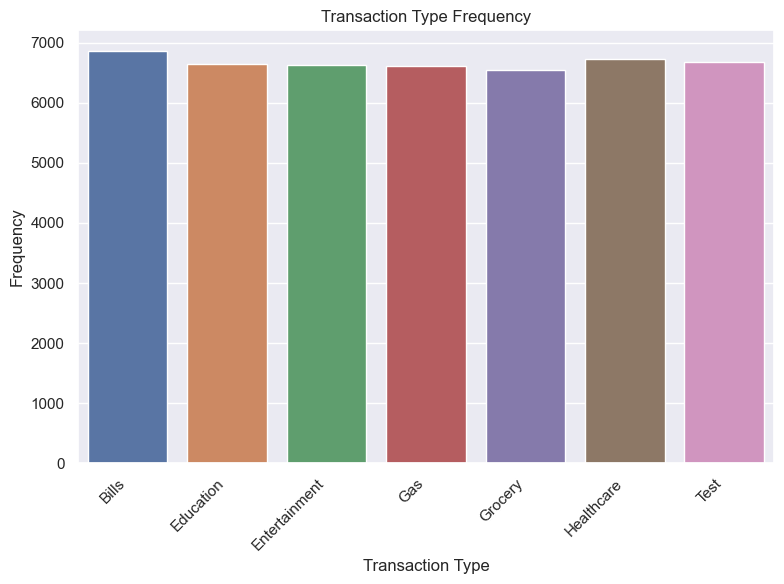

In [48]:
# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)
query = """
SELECT TRANSACTION_TYPE, COUNT(*) AS TRANSACTION_COUNT
FROM CDW_SAPP_CREDIT_CARD
GROUP BY TRANSACTION_TYPE
"""

df = pd.read_sql(query, db)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(8,6)}) # Set the figure size
sns.barplot(x="TRANSACTION_TYPE", y="TRANSACTION_COUNT", data=df)
plt.title("Transaction Type Frequency")
plt.xlabel("Transaction Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right') # Rotate the x-axis labels for better visibility
plt.tight_layout() # Fix  overlapping labels or titles
plt.show()

#### Find and plot which state has a high number of customers.

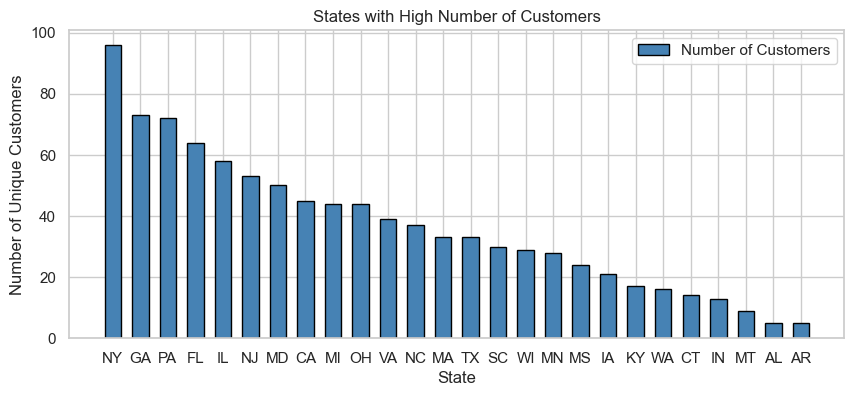

In [22]:
# # # Create a cursor
# cursor = db.cursor()

# # Execute the SQL query to count customers by state
# cursor.execute("SELECT CUST_STATE, COUNT(*) FROM CDW_SAPP_CUSTOMER GROUP BY CUST_STATE ORDER BY COUNT(*) DESC")

# # Fetch the results and store them in a list of tuples
# results = cursor.fetchall()

# # Extract the state names and customer counts from the results
# states = [result[0] for result in results]
# counts = [result[1] for result in results]

# #Create a bar chart of the results
# plt.figure(figsize=(10, 4))
# plt.bar(states, counts, width=0.6, color='steelblue', edgecolor='black')

# # Center the tick marks and labels
# plt.tick_params(axis='x', which='major', pad=15)
# #plt.xticks(rotation=45, ha='right')

# # Add labels and title
# plt.xlabel('State')
# plt.ylabel('Number of Customers')
# plt.title('Number of Customers by State')

# # Add legend
#plt.legend(['Number of Customers'])

# # Show the plot
# plt.show()


# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database )



# query to count the number of unique customers in each state
cursor = db.cursor()
sql = "SELECT UPPER(CUST_STATE), COUNT(DISTINCT SSN) AS COUNT FROM CDW_SAPP_CUSTOMER \
        GROUP BY UPPER(CUST_STATE) ORDER BY COUNT DESC"
cursor.execute(sql)
result = cursor.fetchall()

# states and their counts into separate lists
states = [row[0] for row in result]
counts = [row[1] for row in result]


fig, ax = plt.subplots(figsize=(10,4))
plt.bar(states, counts,width=0.6, color='steelblue', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Number of Unique Customers')
plt.title('States with High Number of Customers')
plt.legend(['Number of Customers'])
plt.show()


#### Find and plot the sum of all transactions for the top 10 customers, and which customer has the highest transaction amount.
hint(use CUST_SSN). 


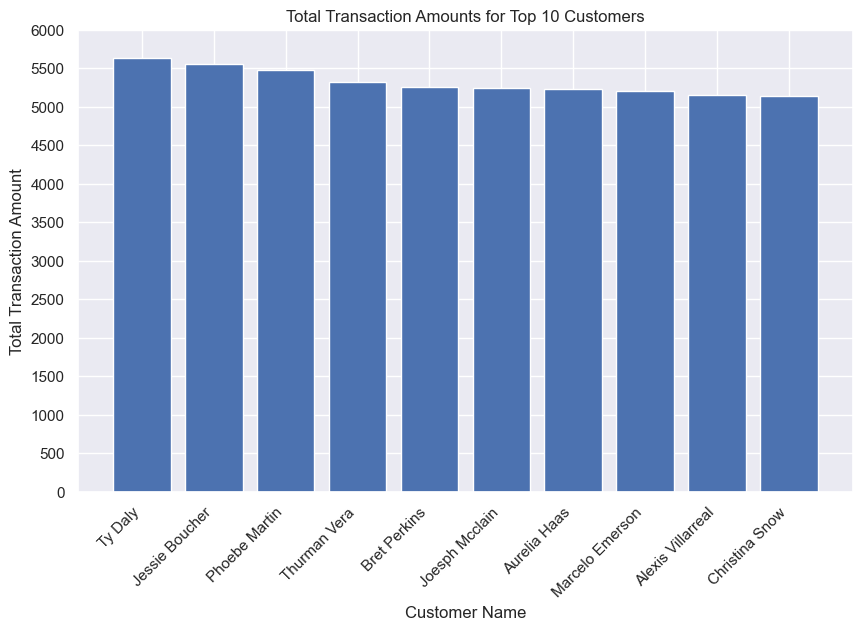

In [44]:
# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

# query to get the total transaction amounts for the top 10 customers
cursor = db.cursor()
sql = "SELECT CONCAT(FIRST_NAME, ' ', LAST_NAME) AS NAME, SUM(TRANSACTION_VALUE) AS TOTAL FROM CDW_SAPP_CREDIT_CARD \
        JOIN CDW_SAPP_CUSTOMER ON CDW_SAPP_CREDIT_CARD.CUST_SSN = CDW_SAPP_CUSTOMER.SSN \
            GROUP BY CUST_SSN ORDER BY TOTAL DESC LIMIT 10"

cursor.execute(sql)
result = cursor.fetchall()

# Extracted the customer names and their total transaction amounts into separate lists
customers = [row[0] for row in result]
totals = [row[1] for row in result]

# bar chart showing the total transaction amounts for the top 10 customers
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(customers, totals)
plt.xlabel('Customer Name')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amounts for Top 10 Customers')
plt.xticks(range(len(customers)), customers, rotation=45, ha='right')
plt.yticks(range(0, int(max(totals))+500, 500))

plt.show()


db.close()




## Overview of LOAN application Data API
Banks deal in all home loans. They have a presence across all urban, semi-urban, and rural areas. Customers first apply for a home loan; after that, a company will validate the customer's eligibility for a loan.
Banks want to automate the loan eligibility process (in real-time) based on customer details provided while filling out the online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History, and others. To automate this process, they have the task of identifying the customer segments to those who are eligible for loan amounts so that they can specifically target these customers. Here they have provided a partial dataset.


API Endpoint: https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json

The above URL allows you to access information about loan application information. This dataset has all of the required fields for a loan application. You can access data from a REST API by sending an HTTP request and processing the response.


In [3]:
# Load data from API endpoint into Pandas dataframe

url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response =requests.get(url)
#response_data = response.json()


In [4]:
print("Status code:", response.status_code)

Status code: 200


In [5]:
# Read the loan data from the API using Pandas
loan_df = pd.read_json("https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json")

In [14]:
#loan_df['Credit_History'] = loan_df['Credit_History'].astype(float)

loan_df_schema=StructType([
StructField("Application_ID", StringType(), True),
StructField("Gender", StringType(), True),
StructField("Married", StringType(), True),
StructField("Dependents", StringType(), True),
StructField("Education", StringType(), True),
StructField("Self_Employed", StringType(), True),
StructField("Credit_History", IntegerType() , True),
StructField("Property_Area", StringType(), True),
StructField("Income", StringType(), True),
StructField("Application_Status", StringType(), True)
])


In [15]:
#createa a new spark session 

spark=SparkSession.builder.appName("convert to spark").getOrCreate()

In [21]:
spark_loan_df=spark.createDataFrame(loan_df,schema=loan_df_schema)

c:\Users\Learner_XZHCG222\Documents\Per Scholas\Data Engineering\repos\Data Engineering - Capstone Project\dataEngProject\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [20]:
# Define the MySQL connection properties
url = "jdbc:mysql://localhost:3306/creditcard_capstone"
table = "CDW_SAPP_loan_application"
properties = {
    "user": user,
    "password": password,
    "driver": "com.mysql.cj.jdbc.Driver"
}

# Write the loan data to the MySQL table
spark_loan_df.write.jdbc(url=url, table=table, mode="overwrite", properties=properties)

Py4JJavaError: An error occurred while calling o136.jdbc.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 4.0 failed 1 times, most recent failure: Lost task 4.0 in stage 4.0 (TID 36) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:55)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 35 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$1(RDD.scala:1011)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.foreachPartition(RDD.scala:1009)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.saveTable(JdbcUtils.scala:867)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:65)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:47)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at org.apache.spark.sql.DataFrameWriter.jdbc(DataFrameWriter.scala:757)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:55)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 35 more


In [11]:
spark_loan_df.write \
    .format("jdbc") \
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("driver", "com.mysql.jdbc.Driver") \
    .option("dbtable", "CDW_SAPP_loan_application") \
    .option("user", user) \
    .option("password", password) \
    .mode("overwrite") \
    #.save()

In [12]:
spark_loan_df.write.jdbc(url='jdbc:mysql://localhost:3306/creditcard_capstone', 
                         table='CDW_SAPP_loan_application', mode='overwrite',
                         
                         properties={'user': user, 'password': password},driver: "com.mysql.cj.jdbc.Driver")

SyntaxError: positional argument follows keyword argument (3782729331.py, line 4)

In [ ]:



# # create new table in the "creditcard_capstone" database
# cursor = cnx.cursor()
# cursor.execute("""
#   CREATE TABLE IF NOT EXISTS CDW_SAPP_loan_application (
#     Loan_ID VARCHAR(50) NOT NULL,
#     Gender VARCHAR(10) NOT NULL,
#     Married VARCHAR(10) NOT NULL,
#     Dependents VARCHAR(10) NOT NULL,
#     Education VARCHAR(20) NOT NULL,
#     Self_Employed VARCHAR(10)NOT NULL,
#     ApplicantIncome INT NOT NULL,
#     CoapplicantIncome INT NOT NULL,
#     LoanAmount FLOAT NOT NULL,
#     Loan_Amount_Term INT NOT NULL,
#     Credit_History FLOAT NOT NULL,
#     Property_Area VARCHAR(20) NOT NULL,
#     Loan_Status VARCHAR(10) NOT NULL
#   )
# """)




In [18]:
# establish a connection to mariadb

try:
    cnx = mysql.connector.connect(user=user, password=password,
                              host=host,
                              database=database)
    cursor = cnx.cursor()

except mysql.connector.Error as err:
    print("Error connecting to MariaDB: {}".format(err))
    exit()
    
#load the data into the new table
# spark_loan_df.write.format("jdbc").options(
#   url="jdbc:mysql://localhost:3306/creditcard_capstone",
#   driver="com.mysql.jdbc.Driver",
#   dbtable="CDW_SAPP_loan_application",
#   user=user,
#    password=password
#  ).mode("overwrite").save()

 
spark_loan_df.write \
    .format("jdbc") \
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("driver", "com.mysql.jdbc.Driver") \
    .option("dbtable", "CDW_SAPP_loan_application") \
    .option("user", user) \
    .option("password", password) \
    .mode("overwrite") \
    .save()

#cnx.commit()
# close the MySQL connection
cnx.close()

Py4JJavaError: An error occurred while calling o124.save.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 2.0 failed 1 times, most recent failure: Lost task 3.0 in stage 2.0 (TID 19) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:55)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 35 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$1(RDD.scala:1011)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.foreachPartition(RDD.scala:1009)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.saveTable(JdbcUtils.scala:867)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:82)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:47)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:55)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 35 more


In [ ]:
# Plot the percentage of applications approved for self-employed applicants




In [ ]:
# Plot the percentage of rejection for married male applicants


In [ ]:
# Stop SparkSession
spark.stop()